# 研究动机

在研究动机部分，研究从时域和频域特征，感知特征，声纹特征三个方面对比现有合成数据方案的合成数据集与真实数据的特征分布差异。并验证提出的克隆方案能否弥合该差异。

## 时域和频域特征分布

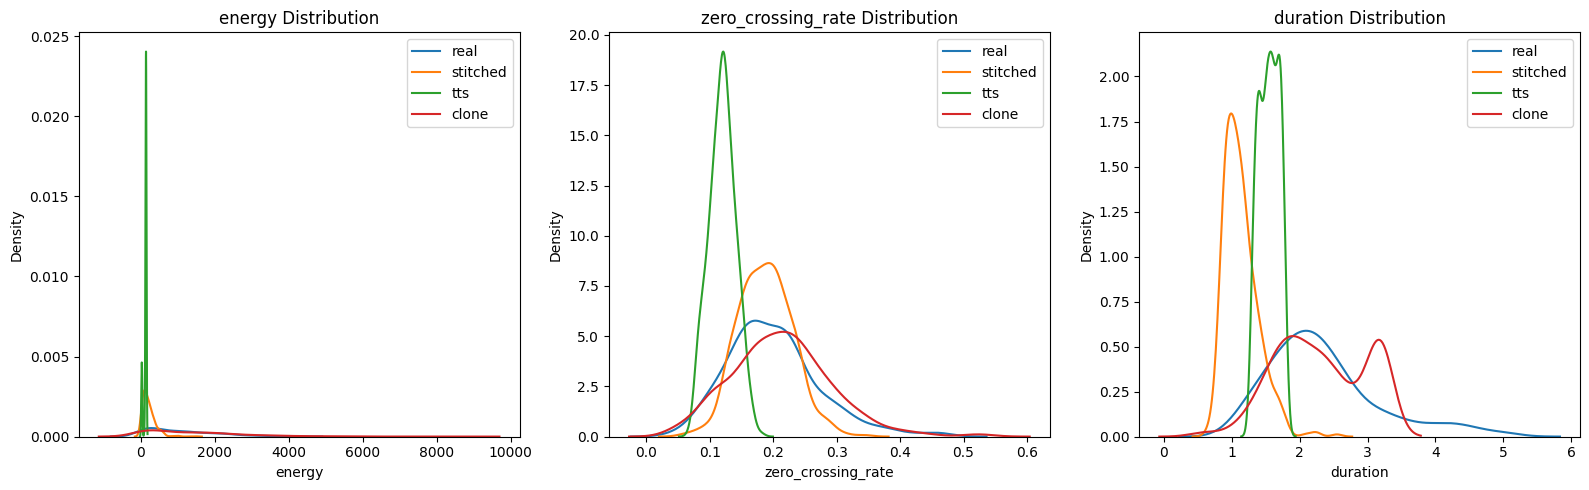

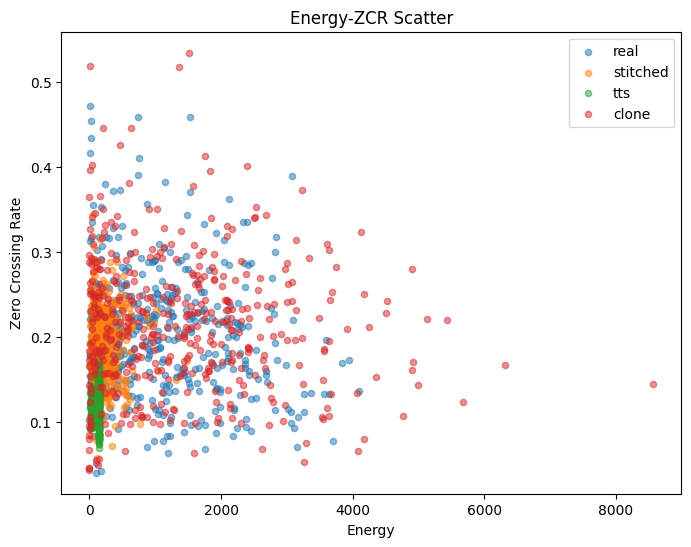

Time-domain feature dispersion (variance):
real:
  energy variance: 830060.9375  coefficient of variation: 0.8552
  zero_crossing_rate variance: 0.0053  coefficient of variation: 0.3641
  duration variance: 0.6779  coefficient of variation: 0.3525
stitched:
  energy variance: 34620.2188  coefficient of variation: 0.8476
  zero_crossing_rate variance: 0.0018  coefficient of variation: 0.2265
  duration variance: 0.0636  coefficient of variation: 0.2214
tts:
  energy variance: 1810.4347  coefficient of variation: 0.3488
  zero_crossing_rate variance: 0.0004  coefficient of variation: 0.1727
  duration variance: 0.0205  coefficient of variation: 0.0923
clone:
  energy variance: 1631338.2500  coefficient of variation: 0.9283
  zero_crossing_rate variance: 0.0062  coefficient of variation: 0.3705
  duration variance: 0.4317  coefficient of variation: 0.2846


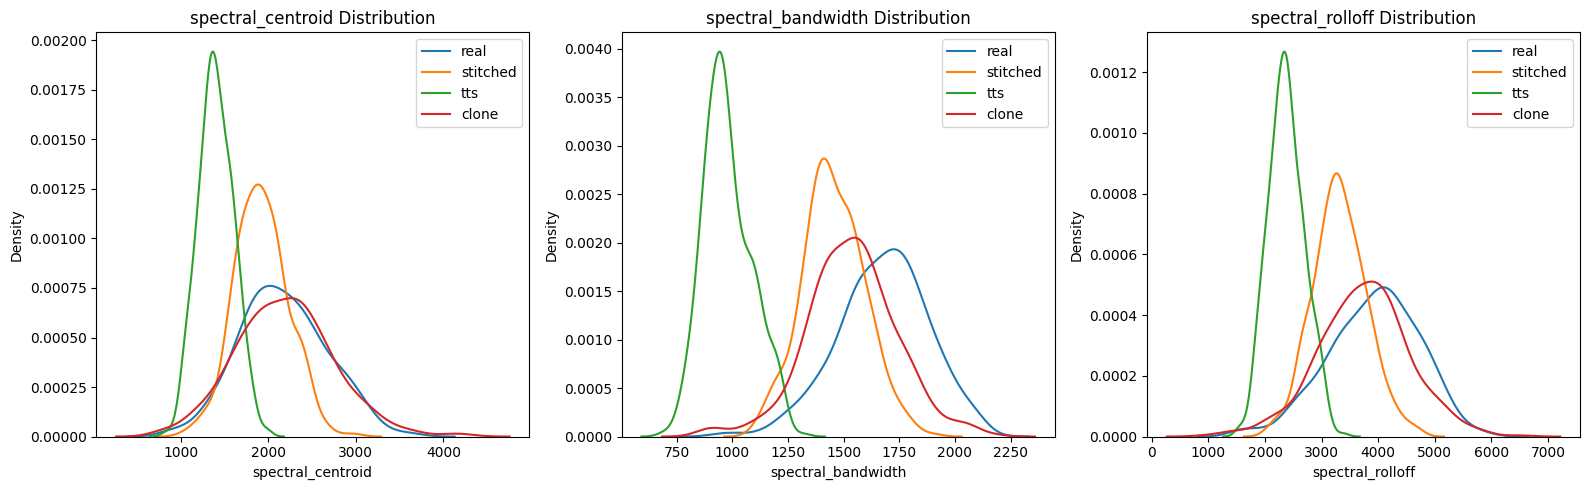

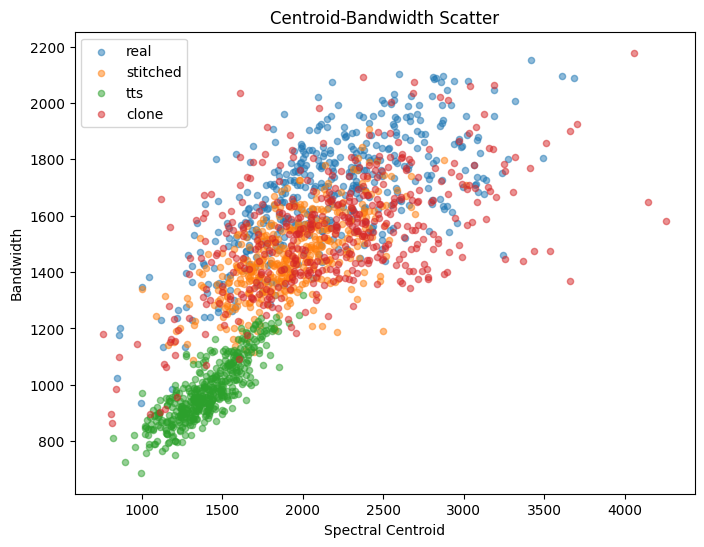


时域特征表格:
--------------------------------------------------------------------------------
指标	真实(real)	拼接(stitched)	TTS(tts)	克隆(clone)
energy变异系数	\textcolor{purple}{0.8552}	0.8476	0.3488	\textbf{0.9283}
energy分布与真实数据集(real)的W距离	\textcolor{purple}{0.0000}	846.1418	943.9473	\textbf{317.9754}
energy分布与真实数据集(real)的JS散度	\textcolor{purple}{0.0000}	0.5024	0.6822	\textbf{0.1989}
zero_crossing_rate变异系数	\textcolor{purple}{0.3641}	0.2265	0.1727	\textbf{0.3705}
zero_crossing_rate分布与真实数据集(real)的W距离	\textcolor{purple}{0.0000}	0.0221	0.0807	\textbf{0.0144}
zero_crossing_rate分布与真实数据集(real)的JS散度	\textcolor{purple}{0.0000}	0.2716	0.5891	\textbf{0.2174}
duration变异系数	\textcolor{purple}{0.3525}	0.2214	0.0923	\textbf{0.2846}
duration分布与真实数据集(real)的W距离	\textcolor{purple}{0.0000}	1.1971	0.8019	\textbf{0.1946}
duration分布与真实数据集(real)的JS散度	\textcolor{purple}{0.0000}	0.6524	0.6367	\textbf{0.3568}

频域特征表格:
--------------------------------------------------------------------------------
指标	真实(real)	拼接(stitched)	TTS(

In [4]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import variation
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import jensenshannon
import pandas as pd

# 输入四个数据集的根目录
real_root = "../data/hey-fire-fox-real-442"
stitched_root = "../data/hey-fire-fox-stitched-442"
tts_root = "../data/tts_dataset/tts_audio-tts-1-442"
clone_root = "../data/clone_dataset/clone_audio-cosyvoice-ref_hey_fire_fox_real_positive-442"

dataset_info = {
    'real': {
        'dir': os.path.join(real_root, 'clips'),
        'tsv': os.path.join(real_root, 'train.tsv')
    },
    'stitched': {
        'dir': os.path.join(stitched_root, 'clips'),
        'tsv': os.path.join(stitched_root, 'train.tsv')
    },
    'tts': {
        'dir': os.path.join(tts_root, 'clips'),
        'tsv': os.path.join(tts_root, 'train.tsv')
    },
    'clone': {
        'dir': os.path.join(clone_root, 'clips'),
        'tsv': os.path.join(clone_root, 'train.tsv')
    }
}

# 读取tsv文件，获取每个数据集的音频文件名
def get_audio_files_from_tsv(tsv_path):
    df = pd.read_csv(tsv_path, sep='\t')
    return df['path'].tolist()

# 特征提取函数
def extract_features(file_path, sr=16000):
    y, _ = librosa.load(file_path, sr=sr)
    energy = np.sum(y ** 2)
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y))
    duration = len(y) / sr
    S, phase = librosa.magphase(librosa.stft(y))
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(S=S, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(S=S, sr=sr))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(S=S, sr=sr, roll_percent=0.85))
    return {
        'energy': energy,
        'zero_crossing_rate': zero_crossing_rate,
        'duration': duration,
        'spectral_centroid': spectral_centroid,
        'spectral_bandwidth': spectral_bandwidth,
        'spectral_rolloff': spectral_rolloff
    }

# 批量提取
features = {k: [] for k in dataset_info}
for name, info in dataset_info.items():
    audio_files = get_audio_files_from_tsv(info['tsv'])
    for fname in audio_files:
        fpath = os.path.join(info['dir'], fname)
        if not os.path.isfile(fpath):
            print(f"Warning: {fpath} does not exist, skip")
            continue
        try:
            feat = extract_features(fpath)
            features[name].append(feat)
        except Exception as e:
            print(f"Error processing {fpath}: {e}")

def feats_to_np(feats, key):
    return np.array([f[key] for f in feats])

def calculate_distribution_metrics(real_data, synthetic_data, bins=50):
    """计算合成数据与真实数据之间的分布相似度指标"""
    
    # 确保数据有效
    if len(real_data) == 0 or len(synthetic_data) == 0:
        return {
            'wasserstein': np.nan,
            'js_divergence': np.nan,
            'histogram_overlap': np.nan,
            'distribution_difference': np.nan
        }
    
    # Wasserstein距离
    w_distance = wasserstein_distance(real_data, synthetic_data)
    
    # 计算JS散度
    hist_real, bin_edges = np.histogram(real_data, bins=bins, density=True)
    hist_synth, _ = np.histogram(synthetic_data, bins=bin_edges, density=True)
    
    # 添加平滑以避免零概率问题
    hist_real = hist_real + 1e-10
    hist_synth = hist_synth + 1e-10
    
    # 重新归一化
    hist_real = hist_real / np.sum(hist_real)
    hist_synth = hist_synth / np.sum(hist_synth)
    
    # 计算JS散度
    js_div = jensenshannon(hist_real, hist_synth)
    
    # 直方图交集相似度
    histogram_overlap = np.sum(np.minimum(hist_real, hist_synth))
    
    # 分布差异指标
    cdf_real = np.cumsum(hist_real)
    cdf_synth = np.cumsum(hist_synth)
    distribution_diff = np.max(np.abs(cdf_real - cdf_synth))
    
    return {
        'wasserstein': w_distance,
        'js_divergence': js_div,
        'histogram_overlap': histogram_overlap,
        'distribution_difference': distribution_diff
    }

# 时域特征分析与可视化
plt.figure(figsize=(16, 5))
for i, key in enumerate(['energy', 'zero_crossing_rate', 'duration']):
    plt.subplot(1, 3, i+1)
    for name in dataset_info:
        arr = feats_to_np(features[name], key)
        if len(arr) > 0:
            sns.kdeplot(arr, label=name)
    plt.title(f'{key} Distribution')
    plt.xlabel(key)
    plt.ylabel('Density')
    plt.legend()
plt.tight_layout()
plt.show()

# 能量-零交叉率散点图
plt.figure(figsize=(8, 6))
for name in dataset_info:
    e = feats_to_np(features[name], 'energy')
    zcr = feats_to_np(features[name], 'zero_crossing_rate')
    if len(e) > 0 and len(zcr) > 0:
        plt.scatter(e, zcr, alpha=0.5, label=name, s=20)
plt.xlabel('Energy')
plt.ylabel('Zero Crossing Rate')
plt.title('Energy-ZCR Scatter')
plt.legend()
plt.show()

# 时域分散度/多样度量化
print("Time-domain feature dispersion (variance):")
for name in dataset_info:
    print(f"{name}:")
    for key in ['energy', 'zero_crossing_rate', 'duration']:
        arr = feats_to_np(features[name], key)
        if len(arr) > 0:
            print(f"  {key} variance: {np.var(arr):.4f}  coefficient of variation: {variation(arr):.4f}")

# 频域特征分析与可视化
plt.figure(figsize=(16, 5))
for i, key in enumerate(['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff']):
    plt.subplot(1, 3, i+1)
    for name in dataset_info:
        arr = feats_to_np(features[name], key)
        if len(arr) > 0:
            sns.kdeplot(arr, label=name)
    plt.title(f'{key} Distribution')
    plt.xlabel(key)
    plt.ylabel('Density')
    plt.legend()
plt.tight_layout()
plt.show()

# 频谱质心-带宽散点图
plt.figure(figsize=(8, 6))
for name in dataset_info:
    sc = feats_to_np(features[name], 'spectral_centroid')
    sb = feats_to_np(features[name], 'spectral_bandwidth')
    if len(sc) > 0 and len(sb) > 0:
        plt.scatter(sc, sb, alpha=0.5, label=name, s=20)
plt.xlabel('Spectral Centroid')
plt.ylabel('Bandwidth')
plt.title('Centroid-Bandwidth Scatter')
plt.legend()
plt.show()
            
# 计算所有数据集和特征的变异系数和相似度指标
time_domain_features = ['energy', 'zero_crossing_rate', 'duration']
frequency_domain_features = ['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff']
all_features = time_domain_features + frequency_domain_features

# 创建结果字典
results = {}

# 对每个特征计算指标
for feature in all_features:
    # 保存每个数据集的变异系数和相似度指标
    cv_values = {}
    wasserstein_values = {}
    js_values = {}
    histogram_overlap_values = {}
    dist_diff_values = {}
    
    # 获取real数据作为参考
    real_data = feats_to_np(features['real'], feature)
    
    # 计算每个数据集的指标
    for name in dataset_info.keys():
        data = feats_to_np(features[name], feature)
        if len(data) > 0:
            # 计算变异系数
            cv = variation(data)
            cv_values[name] = cv
            
            # 计算与real的相似度指标（如果是real自己，则为0或1）
            if name == 'real':
                wasserstein_values[name] = 0
                js_values[name] = 0
                histogram_overlap_values[name] = 1
                dist_diff_values[name] = 0
            else:
                metrics = calculate_distribution_metrics(real_data, data)
                wasserstein_values[name] = metrics['wasserstein']
                js_values[name] = metrics['js_divergence']
                histogram_overlap_values[name] = metrics['histogram_overlap']
                dist_diff_values[name] = metrics['distribution_difference']
    
    # 保存结果
    results[f"{feature}_cv"] = cv_values
    results[f"{feature}_wasserstein"] = wasserstein_values
    results[f"{feature}_js"] = js_values
    results[f"{feature}_overlap"] = histogram_overlap_values
    results[f"{feature}_dist_diff"] = dist_diff_values

# 创建表格
def create_table(feature_group, result_dict):
    # 表头
    headers = ["指标", "真实(real)", "拼接(stitched)", "TTS(tts)", "克隆(clone)"]
    
    # 行数据
    rows = []
    metrics_to_check = []
    
    for feature in feature_group:
        metrics_to_check.extend([
            f"{feature}_cv",
            f"{feature}_wasserstein",
            f"{feature}_js"
        ])
    
    # 添加行
    for metric in metrics_to_check:
        if metric not in result_dict:
            continue
            
        row = []
        
        # 确定指标类型和名称
        if metric.endswith('_cv'):
            feature_name = metric.replace('_cv', '')
            row.append(f"{feature_name}变异系数")
        elif metric.endswith('_wasserstein'):
            feature_name = metric.replace('_wasserstein', '')
            row.append(f"{feature_name}分布与真实数据集(real)的W距离")
        elif metric.endswith('_js'):
            feature_name = metric.replace('_js', '')
            row.append(f"{feature_name}分布与真实数据集(real)的JS散度")
        else:
            continue
            
        # 添加每个数据集的值
        values = []
        for name in ["real", "stitched", "tts", "clone"]:
            if name in result_dict[metric]:
                values.append(result_dict[metric][name])
            else:
                values.append(np.nan)
        
        # 找出最优值（除real外）
        non_real_values = [values[i] for i in range(1, 4) if not np.isnan(values[i])]
        if non_real_values:
            # 对于距离和散度，值越小越好
            if metric.endswith('_wasserstein') or metric.endswith('_js'):
                best_value = min(non_real_values)
            # 对于变异系数和重叠度，值越大越好
            else:
                best_value = max(non_real_values)
        else:
            best_value = None
            
        # 添加每个数据集的值（添加格式化）
        for i, name in enumerate(["real", "stitched", "tts", "clone"]):
            if name in result_dict[metric]:
                val = result_dict[metric][name]
                if name == "real":
                    row.append(f"\\textcolor{{purple}}{{{val:.4f}}}")
                elif best_value is not None and val == best_value:
                    row.append(f"\\textbf{{{val:.4f}}}")
                else:
                    row.append(f"{val:.4f}")
            else:
                row.append("N/A")
                
        rows.append(row)
        
    return headers, rows

# 生成时域特征表格
time_headers, time_rows = create_table(time_domain_features, results)

# 生成频域特征表格
freq_headers, freq_rows = create_table(frequency_domain_features, results)

# 打印表格（原始格式）
print("\n时域特征表格:")
print("-" * 80)
print('\t'.join(time_headers))
for row in time_rows:
    print('\t'.join(map(str, row)))

print("\n频域特征表格:")
print("-" * 80)
print('\t'.join(freq_headers))
for row in freq_rows:
    print('\t'.join(map(str, row)))

## 感知特征分布

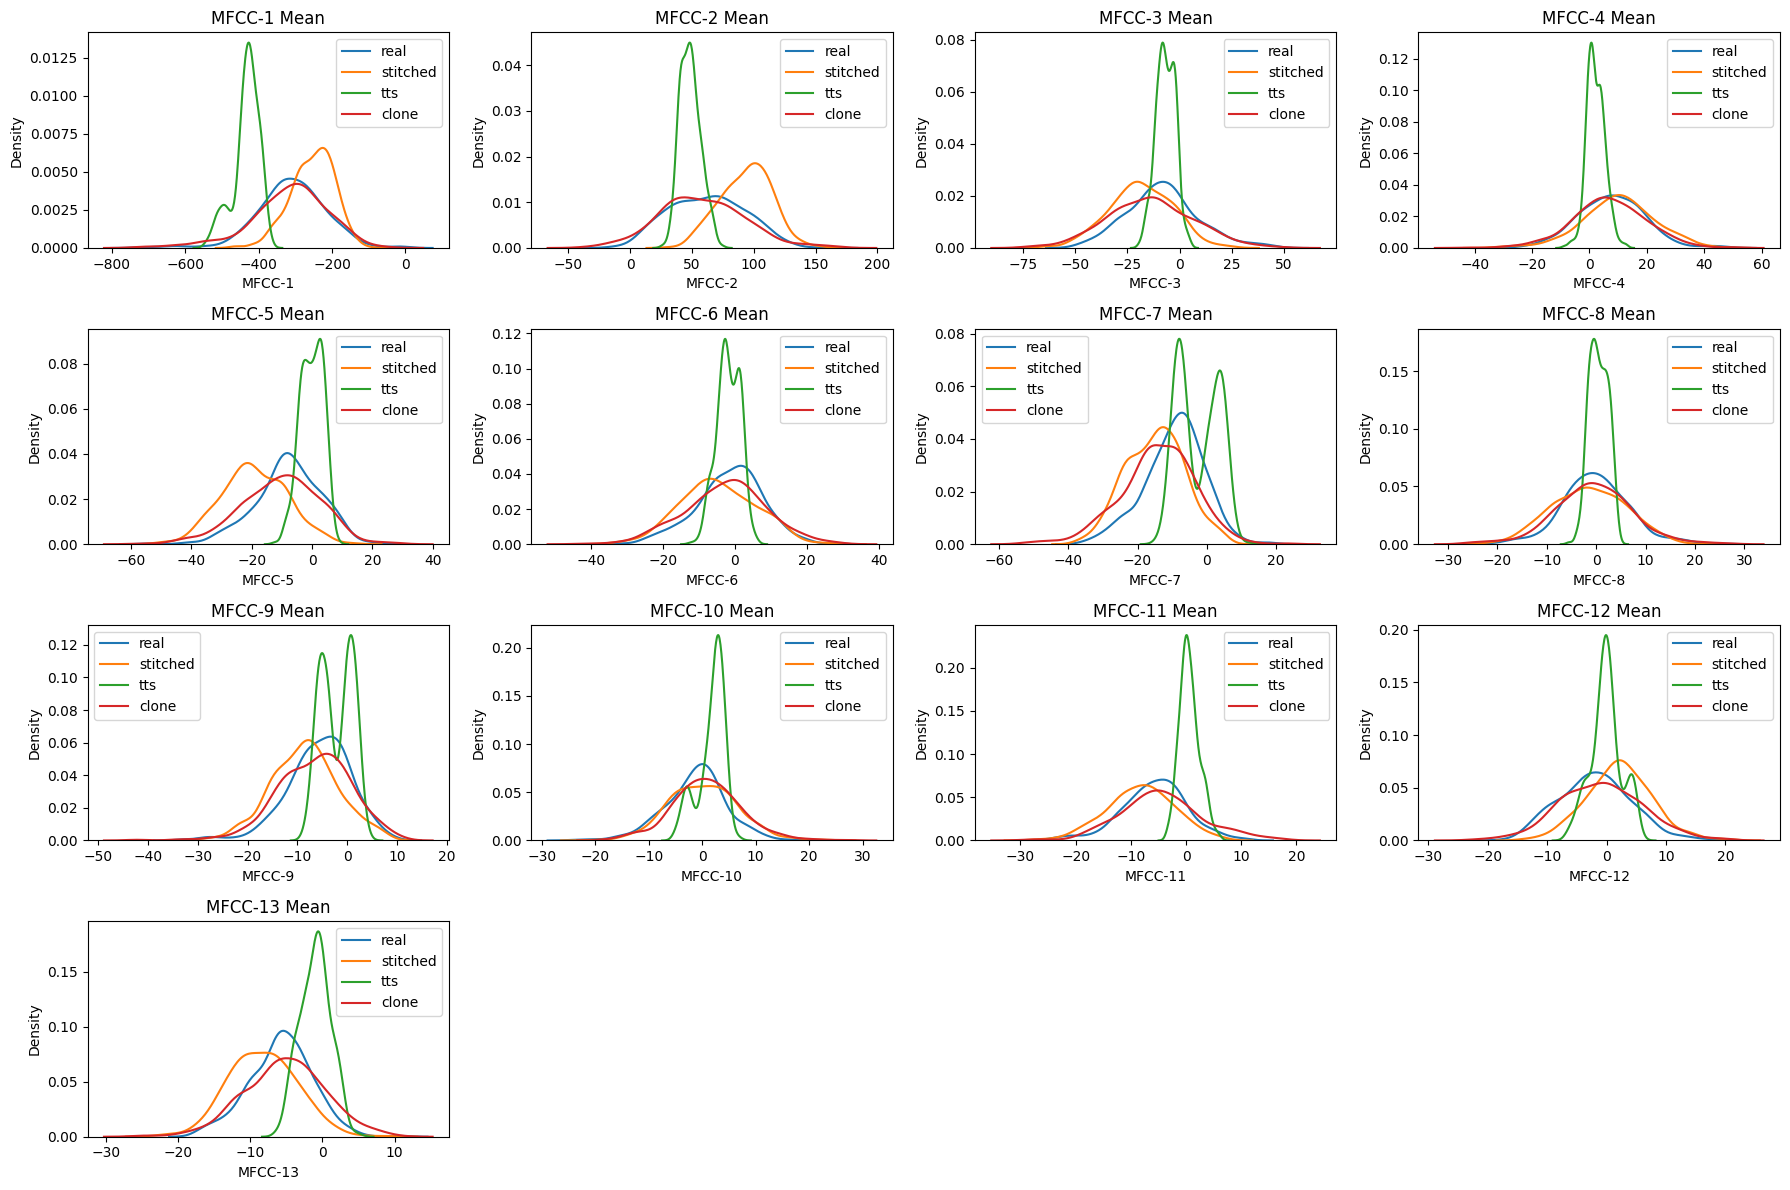

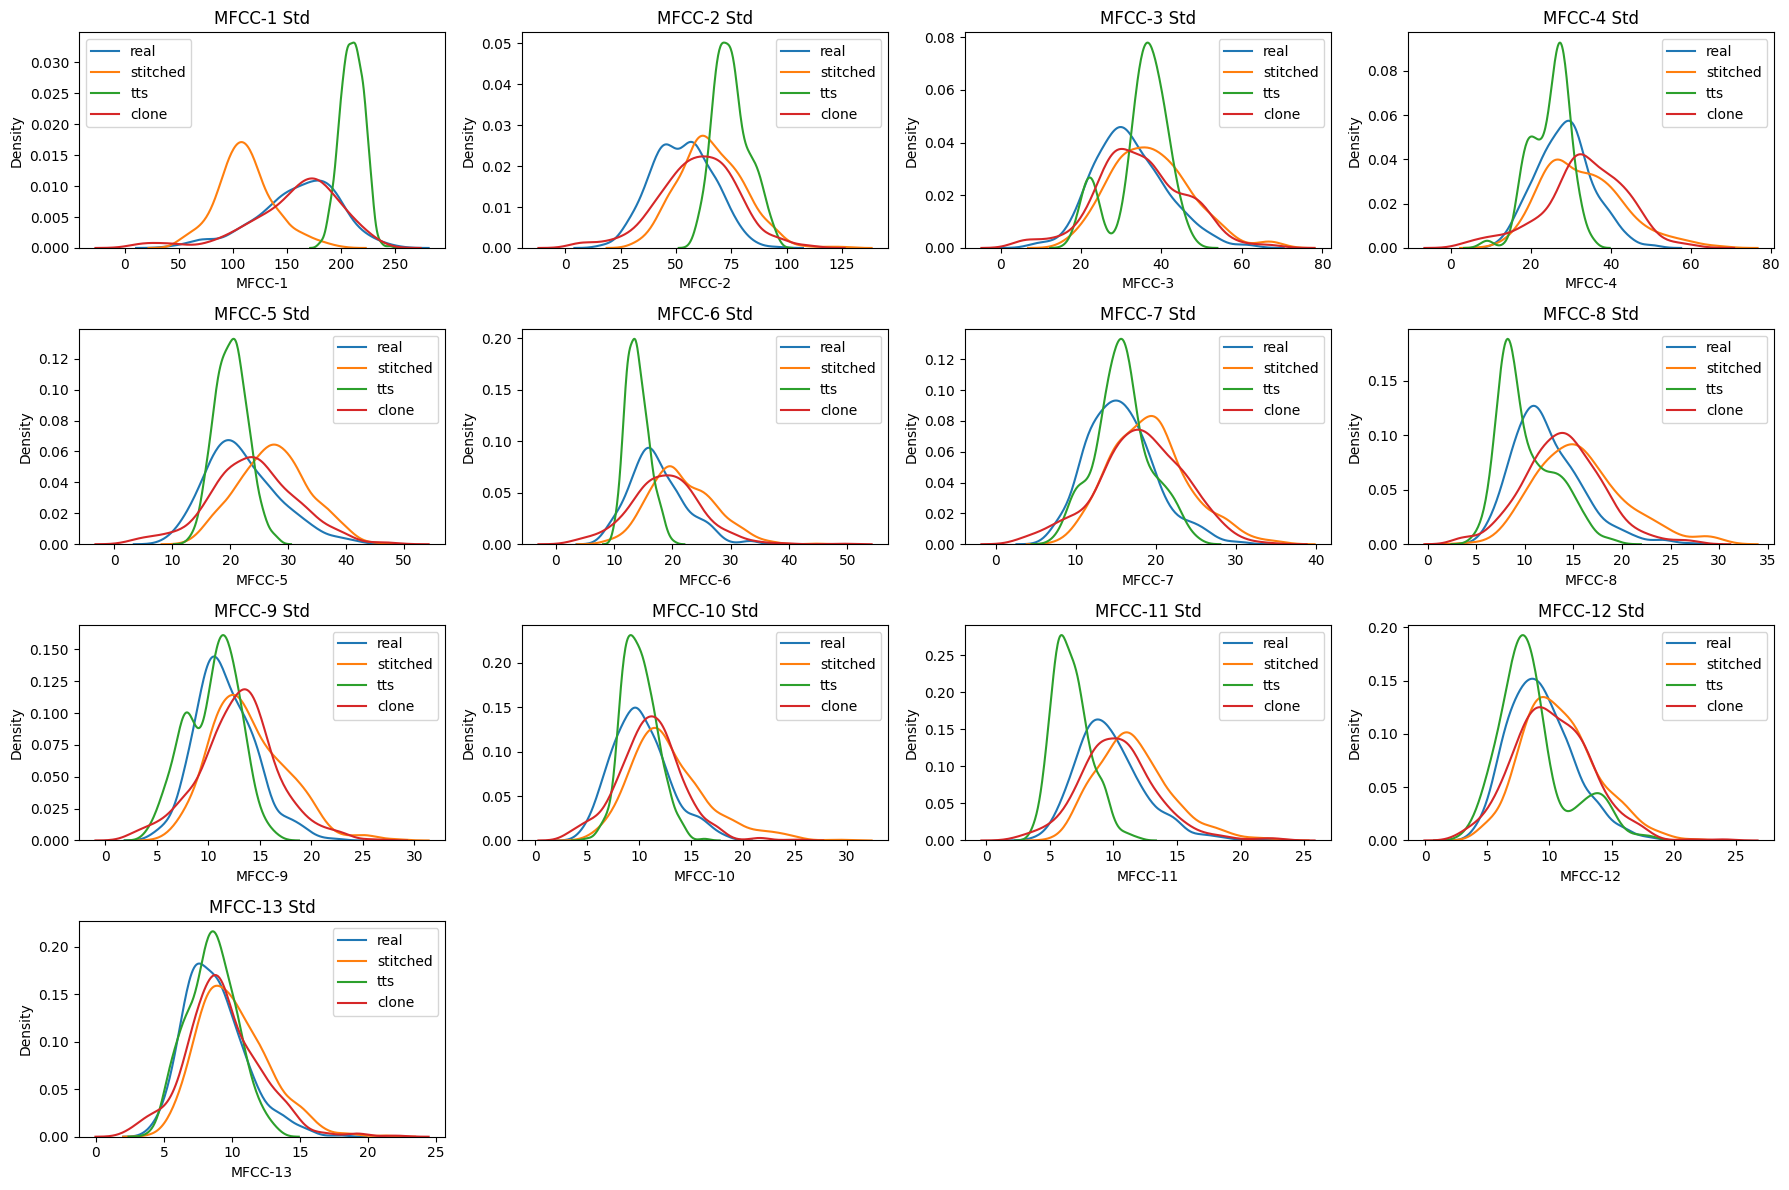

MFCC mean feature dispersion (variance and coefficient of variation):
real:
  MFCC-1 mean variance: 8731.2734  coef. of var.: -0.3019
  MFCC-2 mean variance: 921.5114  coef. of var.: 0.4854
  MFCC-3 mean variance: 294.8574  coef. of var.: -2.1177
  MFCC-4 mean variance: 134.4600  coef. of var.: 1.5001
  MFCC-5 mean variance: 117.3417  coef. of var.: -1.3807
  MFCC-6 mean variance: 84.6329  coef. of var.: -6.7645
  MFCC-7 mean variance: 73.2512  coef. of var.: -0.9212
  MFCC-8 mean variance: 45.6959  coef. of var.: -89.4834
  MFCC-9 mean variance: 41.1293  coef. of var.: -1.1441
  MFCC-10 mean variance: 33.4600  coef. of var.: -4.4984
  MFCC-11 mean variance: 35.2051  coef. of var.: -1.0386
  MFCC-12 mean variance: 36.4722  coef. of var.: -3.1102
  MFCC-13 mean variance: 19.0048  coef. of var.: -0.7574
stitched:
  MFCC-1 mean variance: 3451.0386  coef. of var.: -0.2320
  MFCC-2 mean variance: 430.5848  coef. of var.: 0.2214
  MFCC-3 mean variance: 232.7428  coef. of var.: -0.8216
  MFCC

In [5]:
# 提取MFCC特征（取均值和标准差作为全局感知特征）
def extract_mfcc_features(file_path, sr=16000, n_mfcc=13):
    y, _ = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)
    return {
        'mfcc_mean': mfcc_mean,
        'mfcc_std': mfcc_std
    }

# 批量提取MFCC特征
mfcc_features = {k: [] for k in dataset_info}
for name, info in dataset_info.items():
    audio_files = get_audio_files_from_tsv(info['tsv'])
    for fname in audio_files:
        fpath = os.path.join(info['dir'], fname)
        if not os.path.isfile(fpath):
            print(f"Warning: {fpath} does not exist, skip")
            continue
        try:
            feat = extract_mfcc_features(fpath)
            mfcc_features[name].append(feat)
        except Exception as e:
            print(f"Error processing {fpath}: {e}")

# 合并为矩阵
def mfccs_to_np(feats, key, idx):
    return np.array([f[key][idx] for f in feats])

# 画出每个MFCC维度的分布对比（均值）
plt.figure(figsize=(18, 12))
n_mfcc = 13
for i in range(n_mfcc):
    plt.subplot(4, 4, i+1)
    for name in dataset_info:
        arr = mfccs_to_np(mfcc_features[name], 'mfcc_mean', i)
        if len(arr) > 0:
            sns.kdeplot(arr, label=name)
    plt.title(f'MFCC-{i+1} Mean')
    plt.xlabel(f'MFCC-{i+1}')
    plt.ylabel('Density')
    plt.legend()
plt.tight_layout()
plt.show()

# 画出每个MFCC维度的分布对比（标准差）
plt.figure(figsize=(18, 12))
for i in range(n_mfcc):
    plt.subplot(4, 4, i+1)
    for name in dataset_info:
        arr = mfccs_to_np(mfcc_features[name], 'mfcc_std', i)
        if len(arr) > 0:
            sns.kdeplot(arr, label=name)
    plt.title(f'MFCC-{i+1} Std')
    plt.xlabel(f'MFCC-{i+1}')
    plt.ylabel('Density')
    plt.legend()
plt.tight_layout()
plt.show()

# 计算每个数据集MFCC均值和标准差的分散度（方差和变异系数），并输出
print("MFCC mean feature dispersion (variance and coefficient of variation):")
for name in dataset_info:
    print(f"{name}:")
    for i in range(n_mfcc):
        arr = mfccs_to_np(mfcc_features[name], 'mfcc_mean', i)
        if len(arr) > 0:
            print(f"  MFCC-{i+1} mean variance: {np.var(arr):.4f}  coef. of var.: {variation(arr):.4f}")

print("\nMFCC std feature dispersion (variance and coefficient of variation):")
for name in dataset_info:
    print(f"{name}:")
    for i in range(n_mfcc):
        arr = mfccs_to_np(mfcc_features[name], 'mfcc_std', i)
        if len(arr) > 0:
            print(f"  MFCC-{i+1} std variance: {np.var(arr):.4f}  coef. of var.: {variation(arr):.4f}")

## 声纹特征分布

Loading real dataset: 100%|██████████| 442/442 [00:00<00:00, 26480.25it/s]


real dataset: loaded 442 embedding vectors


Loading stitched dataset: 100%|██████████| 434/434 [00:00<00:00, 28110.13it/s]


stitched dataset: loaded 434 embedding vectors


Loading tts dataset: 100%|██████████| 442/442 [00:00<00:00, 28610.18it/s]


tts dataset: loaded 442 embedding vectors


Loading clone dataset: 100%|██████████| 417/417 [00:00<00:00, 26356.21it/s]

clone dataset: loaded 417 embedding vectors



声纹嵌入特征表格:
--------------------------------------------------------------------------------
               指标                     真实(real)     拼接(stitched) TTS(tts)       克隆(clone)
         声纹嵌入变异系数 \textcolor{purple}{-11.0593}          -8.8827  -0.8507 \textbf{1.1218}
          声纹嵌入总方差  \textcolor{purple}{44.2165} \textbf{45.5197}  36.0519         40.4307
       声纹嵌入平均配对距离   \textcolor{purple}{9.3642}  \textbf{9.4977}   8.3585          8.9361
 声纹嵌入分布与真实数据集的W距离   \textcolor{purple}{0.0000}           0.1602   0.2877 \textbf{0.1370}
声纹嵌入分布与真实数据集的JS散度   \textcolor{purple}{0.0000}           0.2114   0.2937 \textbf{0.2052}


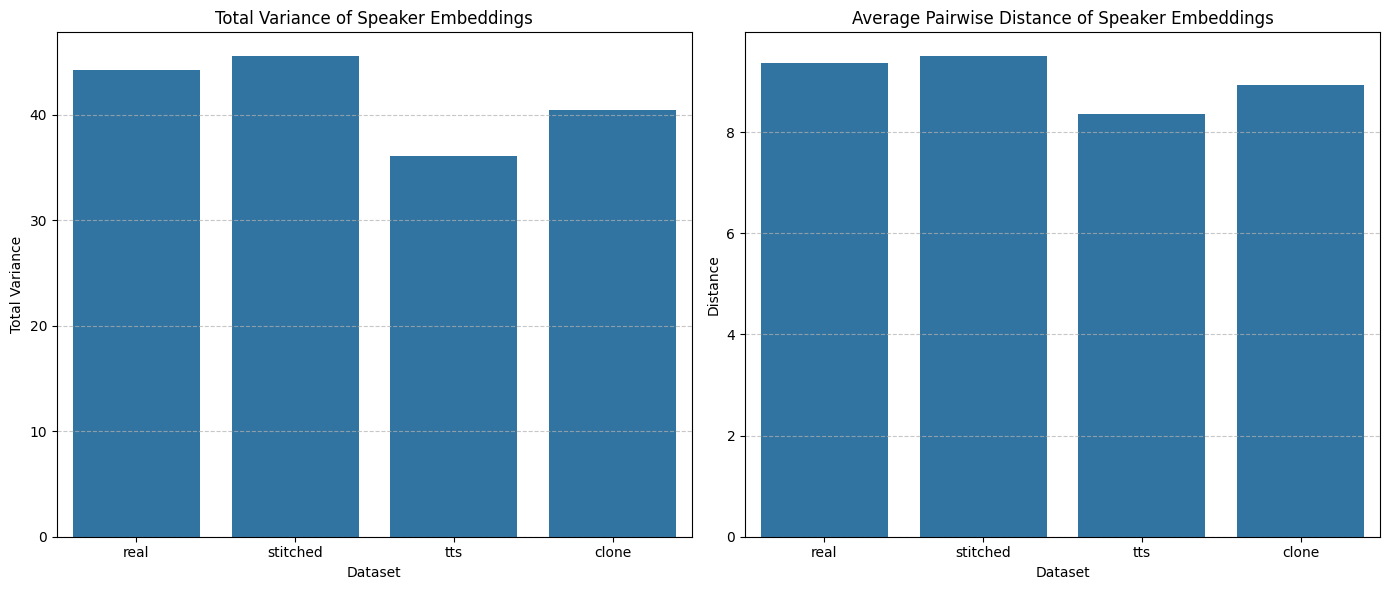

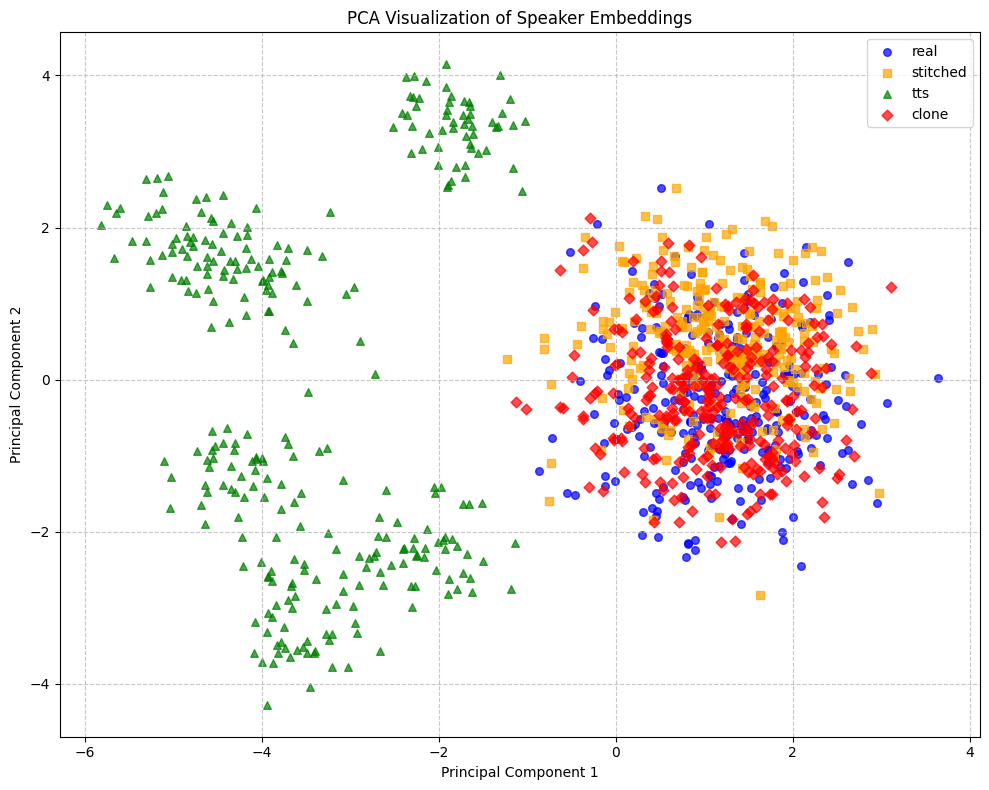

In [6]:
import os
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm
from sklearn.decomposition import PCA

# 设置数据集路径
dataset_paths = {
    'real': "../data/speaker_emb/audio_pos_train_real/emb",
    'stitched': "../data/speaker_emb/audio_pos_train_stitched/emb",
    'tts': "../data/speaker_emb/audio_pos_train_tts/emb",
    'clone': "../data/speaker_emb/audio_pos_train_clone/emb"
}

# 加载所有数据集的声纹嵌入
dataset_embeddings = {}

for dataset_name, dataset_path in dataset_paths.items():
    embeddings = []
    
    # 获取所有的pkl文件
    pkl_files = glob.glob(os.path.join(dataset_path, '*.pkl'))
    
    if not pkl_files:
        print(f"No pkl files found in path: {dataset_path}")
        continue
        
    for pkl_file in tqdm(pkl_files, desc=f'Loading {dataset_name} dataset'):
        try:
            with open(pkl_file, 'rb') as f:
                stat_obj = pickle.load(f)
                
            # 提取平均声纹嵌入
            avg_embedding = stat_obj['avg_embedding']
            embeddings.append(avg_embedding)
        except Exception as e:
            print(f"Error loading {pkl_file}: {e}")
    
    # 转换为numpy数组
    dataset_embeddings[dataset_name] = np.stack(embeddings) if embeddings else np.array([])
    print(f"{dataset_name} dataset: loaded {len(embeddings)} embedding vectors")

# 计算每个数据集的总方差
def calculate_total_variance(embeddings):
    if len(embeddings) == 0:
        return 0
    return np.sum(np.var(embeddings, axis=0))

# 计算每个数据集的变异系数
def calculate_coefficient_of_variation(embeddings):
    if len(embeddings) == 0:
        return 0
    # 计算每个维度的变异系数，然后求平均
    cv_per_dim = np.nanmean([variation(embeddings[:, i]) for i in range(embeddings.shape[1])])
    return cv_per_dim

# 计算每个数据集的平均配对距离
def calculate_avg_pairwise_distance(embeddings):
    if len(embeddings) <= 1:
        return 0
    
    # 如果样本量太大，随机采样以加速计算
    if len(embeddings) > 1000:
        indices = np.random.choice(len(embeddings), 1000, replace=False)
        sample_embeddings = embeddings[indices]
    else:
        sample_embeddings = embeddings
    
    # 计算所有配对之间的欧氏距离
    pairwise_distances = pdist(sample_embeddings, metric='euclidean')
    
    # 返回平均配对距离
    return np.mean(pairwise_distances)

# 计算两组嵌入向量间的Wasserstein距离（对每个维度单独计算，然后求平均）
def calculate_wasserstein_distance(embeddings1, embeddings2):
    if len(embeddings1) == 0 or len(embeddings2) == 0:
        return np.nan
    
    # 获取嵌入维度
    dim = embeddings1.shape[1]
    distances = []
    
    # 对每个维度单独计算Wasserstein距离
    for i in range(dim):
        dist = wasserstein_distance(embeddings1[:, i], embeddings2[:, i])
        distances.append(dist)
    
    # 返回平均距离
    return np.mean(distances)

# 计算两组嵌入向量间的JS散度（对每个维度单独计算，然后求平均）
def calculate_js_divergence(embeddings1, embeddings2, bins=50):
    if len(embeddings1) == 0 or len(embeddings2) == 0:
        return np.nan
    
    # 获取嵌入维度
    dim = embeddings1.shape[1]
    divergences = []
    
    # 对每个维度单独计算JS散度
    for i in range(dim):
        # 计算直方图
        hist1, bin_edges = np.histogram(embeddings1[:, i], bins=bins, density=True)
        hist2, _ = np.histogram(embeddings2[:, i], bins=bin_edges, density=True)
        
        # 添加平滑以避免零概率问题
        hist1 = hist1 + 1e-10
        hist2 = hist2 + 1e-10
        
        # 重新归一化
        hist1 = hist1 / np.sum(hist1)
        hist2 = hist2 / np.sum(hist2)
        
        # 计算JS散度
        js_div = jensenshannon(hist1, hist2)
        divergences.append(js_div)
    
    # 返回平均散度
    return np.mean(divergences)

# 计算分析结果
results = {
    'Dataset': [],
    'Sample Count': [],
    'Coefficient of Variation': [],
    'Total Variance': [],
    'Avg Pairwise Distance': [],
    'W Distance to Real': [],
    'JS Divergence to Real': []
}

# 获取真实数据集的嵌入
real_embeddings = dataset_embeddings.get('real', np.array([]))

for dataset_name, embeddings in dataset_embeddings.items():
    # 添加数据集名称
    results['Dataset'].append(dataset_name)
    
    # 添加样本数量
    results['Sample Count'].append(len(embeddings))
    
    # 计算变异系数
    if len(embeddings) > 0:
        cv = calculate_coefficient_of_variation(embeddings)
        results['Coefficient of Variation'].append(cv)
    else:
        results['Coefficient of Variation'].append(np.nan)
    
    # 计算总方差
    if len(embeddings) > 0:
        total_var = calculate_total_variance(embeddings)
        results['Total Variance'].append(total_var)
    else:
        results['Total Variance'].append(np.nan)
    
    # 计算平均配对距离
    if len(embeddings) > 1:
        avg_dist = calculate_avg_pairwise_distance(embeddings)
        results['Avg Pairwise Distance'].append(avg_dist)
    else:
        results['Avg Pairwise Distance'].append(np.nan)
    
    # 计算与真实数据集的Wasserstein距离和JS散度
    if dataset_name == 'real' or len(real_embeddings) == 0 or len(embeddings) == 0:
        # 如果是真实数据集本身，或者缺少数据，距离为0或NaN
        w_dist = 0 if dataset_name == 'real' else np.nan
        js_div = 0 if dataset_name == 'real' else np.nan
    else:
        # 计算与真实数据集的距离
        w_dist = calculate_wasserstein_distance(real_embeddings, embeddings)
        js_div = calculate_js_divergence(real_embeddings, embeddings)
    
    results['W Distance to Real'].append(w_dist)
    results['JS Divergence to Real'].append(js_div)

# 创建结果表格
results_df = pd.DataFrame(results)


# 找出最佳值索引（非real）
def find_best_index(data, is_lower_better=True):
    if len(data) <= 1:
        return None
    
    non_real_values = [data[i] for i in range(1, len(data)) if not np.isnan(data[i])]
    if not non_real_values:
        return None
    
    if is_lower_better:
        best_value = min(non_real_values)
    else:
        best_value = max(non_real_values)
    
    # 获取索引（跳过第一个real数据集）
    for i in range(1, len(data)):
        if data[i] == best_value:
            return i
    
    return None

# 格式化表格数据
formatted_data = {
    '指标': [
        '声纹嵌入变异系数', 
        '声纹嵌入总方差', 
        '声纹嵌入平均配对距离',
        '声纹嵌入分布与真实数据集的W距离',
        '声纹嵌入分布与真实数据集的JS散度'
    ],
    '真实(real)': [],
    '拼接(stitched)': [],
    'TTS(tts)': [],
    '克隆(clone)': []
}

# 获取各列数据
cv_values = results_df['Coefficient of Variation'].tolist()
var_values = results_df['Total Variance'].tolist()
dist_values = results_df['Avg Pairwise Distance'].tolist()
w_dist_values = results_df['W Distance to Real'].tolist()
js_div_values = results_df['JS Divergence to Real'].tolist()

# 找出最佳值（非real）
cv_best_idx = find_best_index(cv_values, False)  # 变异系数越大越好
var_best_idx = find_best_index(var_values, False)  # 方差越大越好
dist_best_idx = find_best_index(dist_values, False)  # 配对距离越大越好
w_dist_best_idx = find_best_index(w_dist_values, True)  # Wasserstein距离越小越好
js_div_best_idx = find_best_index(js_div_values, True)  # JS散度越小越好

# 填充表格数据
dataset_names = results_df['Dataset'].tolist()
for i, dataset in enumerate(dataset_names):
    col_name = {
        'real': '真实(real)',
        'stitched': '拼接(stitched)',
        'tts': 'TTS(tts)',
        'clone': '克隆(clone)'
    }.get(dataset, dataset)
    
    # 格式化变异系数
    if i == 0:  # real
        formatted_data[col_name].append(f"\\textcolor{{purple}}{{{cv_values[i]:.4f}}}")
    elif i == cv_best_idx:
        formatted_data[col_name].append(f"\\textbf{{{cv_values[i]:.4f}}}")
    else:
        formatted_data[col_name].append(f"{cv_values[i]:.4f}")
    
    # 格式化总方差
    if i == 0:  # real
        formatted_data[col_name].append(f"\\textcolor{{purple}}{{{var_values[i]:.4f}}}")
    elif i == var_best_idx:
        formatted_data[col_name].append(f"\\textbf{{{var_values[i]:.4f}}}")
    else:
        formatted_data[col_name].append(f"{var_values[i]:.4f}")
    
    # 格式化平均配对距离
    if i == 0:  # real
        formatted_data[col_name].append(f"\\textcolor{{purple}}{{{dist_values[i]:.4f}}}")
    elif i == dist_best_idx:
        formatted_data[col_name].append(f"\\textbf{{{dist_values[i]:.4f}}}")
    else:
        formatted_data[col_name].append(f"{dist_values[i]:.4f}")
    
    # 格式化Wasserstein距离
    if i == 0:  # real
        formatted_data[col_name].append(f"\\textcolor{{purple}}{{{w_dist_values[i]:.4f}}}")
    elif i == w_dist_best_idx:
        formatted_data[col_name].append(f"\\textbf{{{w_dist_values[i]:.4f}}}")
    else:
        formatted_data[col_name].append(f"{w_dist_values[i]:.4f}")
    
    # 格式化JS散度
    if i == 0:  # real
        formatted_data[col_name].append(f"\\textcolor{{purple}}{{{js_div_values[i]:.4f}}}")
    elif i == js_div_best_idx:
        formatted_data[col_name].append(f"\\textbf{{{js_div_values[i]:.4f}}}")
    else:
        formatted_data[col_name].append(f"{js_div_values[i]:.4f}")

# 打印表格
print("\n声纹嵌入特征表格:")
print("-" * 80)

formatted_df = pd.DataFrame(formatted_data)
print(formatted_df.to_string(index=False))

# 绘制结果图表
plt.figure(figsize=(14, 6))

# 总方差柱状图
plt.subplot(1, 2, 1)
sns.barplot(x='Dataset', y='Total Variance', data=results_df)
plt.title('Total Variance of Speaker Embeddings')
plt.ylabel('Total Variance')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 平均配对距离柱状图
plt.subplot(1, 2, 2)
sns.barplot(x='Dataset', y='Avg Pairwise Distance', data=results_df)
plt.title('Average Pairwise Distance of Speaker Embeddings')
plt.ylabel('Distance')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 使用PCA可视化嵌入分布
plt.figure(figsize=(10, 8))
pca = PCA(n_components=2)

# 准备包含所有数据集的合并数据用于PCA拟合
all_embeddings = []
for embeddings in dataset_embeddings.values():
    if len(embeddings) > 0:
        all_embeddings.append(embeddings)
        
if all_embeddings:
    all_embeddings_array = np.vstack(all_embeddings)
    pca.fit(all_embeddings_array)

    # 在同一个PCA空间中绘制所有数据集
    colors = ['blue', 'orange', 'green', 'red']
    markers = ['o', 's', '^', 'D']

    for i, (dataset_name, embeddings) in enumerate(dataset_embeddings.items()):
        if len(embeddings) > 0:
            # 为了提高可视化效果，如果样本太多，随机采样
            max_samples = min(300, len(embeddings))
            if len(embeddings) > max_samples:
                indices = np.random.choice(len(embeddings), max_samples, replace=False)
                embeddings_sample = embeddings[indices]
            else:
                embeddings_sample = embeddings
                
            # PCA转换
            embeddings_pca = pca.transform(embeddings_sample)
            
            # 绘制散点图
            plt.scatter(
                embeddings_pca[:, 0], 
                embeddings_pca[:, 1], 
                c=colors[i], 
                marker=markers[i], 
                label=dataset_name,
                alpha=0.7,
                s=30
            )

    plt.title('PCA Visualization of Speaker Embeddings')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
plt.tight_layout()
plt.show()